## Import des données et création de la table des produits

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#Chargement du dataframe
df_customer = pd.read_csv('./csv/shopping_behavior_updated.csv', sep=";")

u_products = df_customer['Item Purchased'].unique()

data = {}
dataReview = {}

for i, row in df_customer.iterrows():
    items = row['Item Purchased'].split(', ')
    review = row['Review Rating']
    indice = 0
    for item in items:
        if item not in data:
            data[item] = [0] * len(df_customer)
            dataReview[item + "_review"] = [0] * len(df_customer)
        data[item][i] += 1
        if dataReview[item + "_review"][i] == 0:
            dataReview[item + "_review"][i] = review
        else:
            dataReview[item + "_review"][i] = (review + dataReview[item + "_review"][i])/2
    
df_review_table = pd.DataFrame(dataReview)


#On supprime les colonnes non pertinentes 
df_customer.drop(columns=['Item Purchased'], inplace=True)
df_customer.drop(columns=['Customer ID'], inplace=True)
df_customer.drop(columns=['Category'], inplace=True)
df_customer.drop(columns=['Purchase Amount (USD)'], inplace=True)
df_customer.drop(columns=['Previous Purchases'], inplace=True)
df_customer.drop(columns=['Color'], inplace=True)
df_customer.drop(columns=['Review Rating'], inplace=True)
df_customer.drop(columns=['Size'], inplace=True)

df_review_table.to_csv('./csv/review_table_temp.csv', sep=";", index=False)

print(df_customer.head(5))

   Age Gender       Location Subscription Status Frequency of Purchases  \
0   19   Male          Maine                 Yes            Fortnightly   
1   50   Male  Massachusetts                 Yes                 Weekly   
2   21   Male   Rhode Island                 Yes                 Weekly   
3   45   Male         Oregon                 Yes               Annually   
4   46   Male        Wyoming                 Yes                 Weekly   

   Season  Shipping Type Discount Applied Promo Code Used Payment Method  
0  Winter        Express              Yes             Yes           Cash  
1  Spring  Free Shipping              Yes             Yes    Credit Card  
2  Spring   Next Day Air              Yes             Yes         PayPal  
3  Spring  Free Shipping              Yes             Yes         PayPal  
4  Summer       Standard              Yes             Yes          Venmo  


## Encodage des données

In [10]:
import pickle as pk

cols_cat_info = [1,2,3,4,5,6,7,8,9]

#On créer une copie de notre dataframe source
df_grouped_customer = df_customer.copy()

#On supprime la colonne des achats

a_grouped_customer = df_grouped_customer.values
#Encodage des colonnes catégorielles
label_encoders_info = [LabelEncoder() for _ in range(len(cols_cat_info))]
for i, col_idx in enumerate(cols_cat_info):
    a_grouped_customer[:, col_idx] = label_encoders_info[i].fit_transform(a_grouped_customer[:, col_idx])

with open('./pickles/label_encoders_recommandation.pkl', 'wb') as f:
    pk.dump(label_encoders_info, f)
#Print des données encodées
print(a_grouped_customer[0])

a_product_review = df_review_table.values

[19 1 18 1 3 3 1 1 1 1]


## Création du modèle de recommandation

Nous entrainons notre modèle pour reconnaitre les k-voisins les plus proches de chaque client
Notre prédiction montre l'avis de notre client sur chaque produit, en se basant sur ses avis et les avis des clients les plus proches de lui.

Nous considerons que si un avis est ajouté à la ligne des avis déjà réalisés par le client, alors cet avis concerne un produit acheté par un des plus proches voisins du client.
Nous considerons, que malgrès le fait la review générée n'ai pas une grande valeur, elle concerne tout de même un produit intéressant pour le client.

In [11]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=4)
neigh.fit(a_grouped_customer, a_product_review)

y_pred = neigh.predict([a_grouped_customer[0]])
print(neigh.predict([a_grouped_customer[0]]))



[[1.975 0.675 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.7   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]]


## Calcul importance des variables pour la recommandation

Index(['Age', 'Gender', 'Location', 'Subscription Status',
       'Frequency of Purchases', 'Season', 'Shipping Type', 'Discount Applied',
       'Promo Code Used', 'Payment Method'],
      dtype='object')
Liste des variables selon leur importance dans l'ordre décroissant
Location
Age
Shipping Type
Payment Method
Frequency of Purchases
Season
Gender
Subscription Status
Promo Code Used
Discount Applied


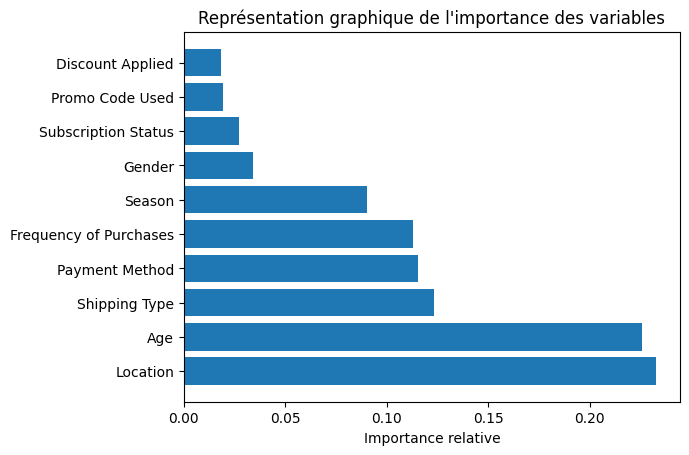

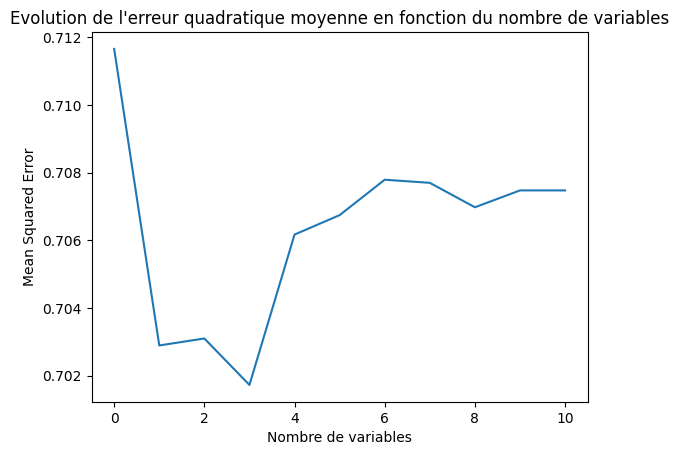

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Diviser les données en ensembles d'apprentissage et de test
x_train, x_test, y_train, y_test = train_test_split(a_grouped_customer, a_product_review, test_size=0.5, random_state=1)



# Entraîner un modèle RandomForestRegressor pour l'importance des caractéristiques
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(x_train, y_train)
importances = rf_regressor.feature_importances_


sorted_idx = np.argsort(importances)[::-1]
features = df_grouped_customer.columns

print(features)
# Afficher l'importance des variables
print("Liste des variables selon leur importance dans l'ordre décroissant")
for i in sorted_idx:
    print(features[i])

# Représentation graphique de l'importance des variables
padding = np.arange(x_train.size/x_train.shape[0]) + 0.5 
plt.barh(padding, importances[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Importance relative")
plt.title("Représentation graphique de l'importance des variables") 
plt.show()

# Entraîner un modèle MLPRegressor
mlp_regressor = KNeighborsRegressor(n_neighbors=4)
scores = np.zeros(x_train.shape[1] + 1)

# Evaluer l'accuracy en fonction du nombre de variables
for f in np.arange(0, x_train.shape[1] + 1):
    X1_f = x_train[:, sorted_idx[:f+1]]
    X2_f = x_test[:, sorted_idx[:f+1]]
    mlp_regressor.fit(X1_f, y_train)
    Y_pred = mlp_regressor.predict(X2_f)
    scores[f] = mean_squared_error(y_test, Y_pred)

# Afficher l'évolution de l'accuracy en fonction du nombre de variables
plt.plot(scores)
plt.xlabel("Nombre de variables")
plt.ylabel("Mean Squared Error")
plt.title("Evolution de l'erreur quadratique moyenne en fonction du nombre de variables")
plt.show()


## Recherche des meilleurs hyperparamètres

In [13]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(a_grouped_customer[:,sorted_idx[::3]],a_product_review, test_size=0.4, random_state=1)  # random_state=1 ici

# Créer le modèle RegressorChain avec KNeighborsRegressor comme base estimator

chain_model = KNeighborsRegressor()

# Définir les hyperparamètres à optimiser
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30]
}

# Initialiser la GridSearchCV avec random_state=1
grid_search = GridSearchCV(chain_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Effectuer la recherche sur grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score (neg_mean_squared_error):", grid_search.best_score_)

# Évaluer le modèle sur l'ensemble de test
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error sur l'ensemble de test:", mse)


Meilleurs paramètres: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'weights': 'uniform'}
Meilleur score (neg_mean_squared_error): -0.6663459921301637
Mean Squared Error sur l'ensemble de test: 0.6826846564102567


## Sauvegarde du modèle

In [14]:
model_to_pickle = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='ball_tree', leaf_size=20)
model_to_pickle.fit(a_grouped_customer, a_product_review)

with open('./pickles/knn_recommandation.pkl', 'wb') as f:
    pk.dump(neigh, f)

## Création de la fonction de recommandation à partir de la prédiction du modèle

In [15]:
df_customer = pd.read_csv('./csv/shopping_behavior_updated.csv', sep=";")

#On récupère l'ensemble des valeurs unique des produits
u_products = df_customer['Item Purchased'].str.split(', ', expand = True).stack().unique()

def getItemsToRecommend(uniqueProducts, idClient, prediction): 
    recommendedItems = []
    alreadyBought = []
    #On récupère les produits déjà achetés
    for i in range(len(a_product_review[idClient])):
        if a_product_review[idClient][i] > 0:
            print(uniqueProducts[i])
            alreadyBought.append(uniqueProducts[i])
            
    #On récupère les produits recommandés
    for j in range(len(prediction[0])):
        if prediction[0][j] > 0:
            #Si le produit n'est pas déjà acheté on l'ajoute à la liste des recommandations
            if uniqueProducts[j] not in alreadyBought:
                recommendedItems.append(uniqueProducts[j])
    return recommendedItems


print(getItemsToRecommend(u_products, 0, y_pred))

Sweater
['Sandals', 'Shirt', 'Hat', 'Socks', 'Boots']
